# Employment Scam Aegean Dataset
## 0.0 Imports and global settings

In [2]:
import library as lib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
sns.set(style='ticks', palette='RdYlGn', font_scale=1.7, rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [4]:
df = pd.read_csv("./fake_job_postings.csv",index_col='job_id')

In [5]:
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

In [12]:
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0


In [15]:
df.sample(n=50)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
15317,English Teacher Abroad,"US, IL, Springfield",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,0
4898,Customer Service Associate - Part Time,"US, NC, Charlotte",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 1 year custome...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0
2648,Food Quality,"US, IL, Chicago",NaN,NaN,We Provide Full Time Permanent Positions for m...,(We have more than 1500+ Job openings in our w...,NaN,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
1249,Payroll Tax Analyst,"US, NY, NEW YORK",Operations,NaN,Namely is the leading end-to-end HR and payrol...,Namely is an agile startup dedicated to buildi...,Who you are:You will be the key person respons...,NaN,0,1,1,Full-time,NaN,NaN,Information Technology and Services,NaN,0
9823,Atlassian JIRA Developer (AJD),"GR, I, Athens",NaN,NaN,"Cententia, founded in 1998, is the market lead...","Cententia is looking for a well-rounded, smart...",Required Skills:University Degree preferably i...,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Consulting,0
1632,Administrative Assistant,"GR, I, Acharnes",Secretary / Support,NaN,Mindworks interactive is one of the fastest gr...,Mindworks is looking for an Administrative Ass...,The ideal candidate should:have a Degree (univ...,Why Work for MindworksWe dream big. We like to...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
3940,"International Broadcaster, Tigrigna Language","US, DC, Washington",NaN,NaN,Applied Memetics LLC is a professional service...,The International Broadcaster shall have at le...,The International Broadcaster shall properly c...,NaN,0,1,0,Full-time,NaN,Bachelor's Degree,Broadcast Media,NaN,0
555,Manager - Life Sciences Consulting,"US, IL, Lake Forest",NaN,NaN,Praxis Life Sciences is a dynamic project mana...,Manager-level candidate should have an entrepr...,Industry Experience and KnowledgeHas at least ...,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Management Consulting,Consulting,0
14340,Front End Developer,"GB, LND, London",Tech,NaN,10 Minutes With is an educational website desi...,We are seeking a Web Designer (Front End Devel...,Required SkillsProven knowledge and experience...,NaN,0,1,0,Full-time,Associate,Bachelor's Degree,Information Technology and Services,Information Technology,0


## 1 Missing values
Let's have a look at the data and see if there are any missing values.

In [6]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

,Legit_HasValue,Legit_IsNA,Fraud_HasValue,Fraud_IsNA
Columns,,,,
title,100.0,0.0,100.0,0.0
location,98.1,1.9,97.8,2.2
department,35.3,64.7,38.7,61.3
salary_range,15.5,84.5,25.8,74.2
company_profile,84.0,16.0,32.2,67.8
description,100.0,0.0,99.9,0.1
requirements,85.1,14.9,82.2,17.8
benefits,59.8,40.2,58.0,42.0
telecommuting,100.0,0.0,100.0,0.0


In [33]:
for n,i in enumerate(df.columns):
    print(f'| {n+1:0>2d} | {df.columns[n]} |  |')

| 01 | title |  |
| 02 | location |  |
| 03 | department |  |
| 04 | salary_range |  |
| 05 | company_profile |  |
| 06 | description |  |
| 07 | requirements |  |
| 08 | benefits |  |
| 09 | telecommuting |  |
| 10 | has_company_logo |  |
| 11 | has_questions |  |
| 12 | employment_type |  |
| 13 | required_experience |  |
| 14 | required_education |  |
| 15 | industry |  |
| 16 | function |  |
| 17 | fraudulent |  |


## Insights
This dataset contains 17880 jobs and a maximum of 16 characteristics are given to each jobs. On top of this information, all jobs entry have manually been assigned a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers being flagged as legitimate whilst 866 were flagged as fraudulent.

_Note:This assignment was done manually and errors might have occured._

The informations given for each job is separated in the following variables:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a positions as Office manager in Warsaw, PL.

17014


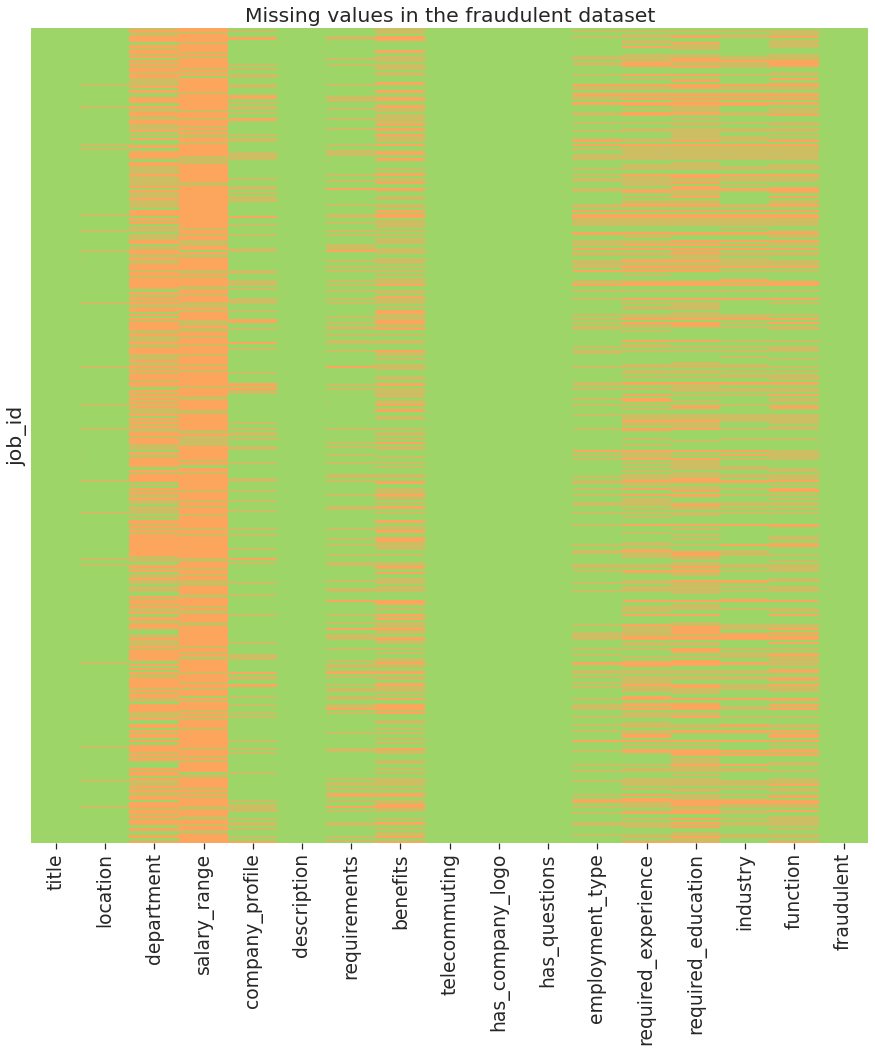

In [7]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


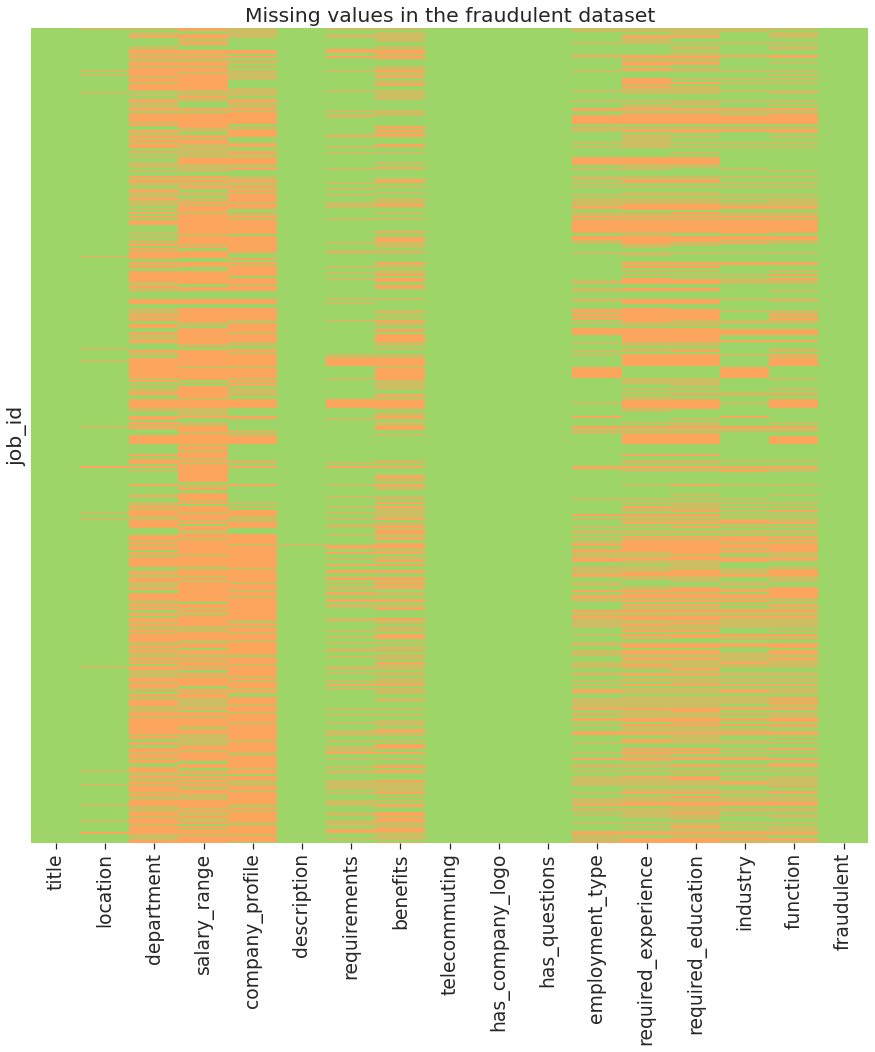

In [8]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

# Text fields

It seems like the fraudsters are struggling with the company profiles... Let's look at text fields in general to see how creative the fraudsters are.

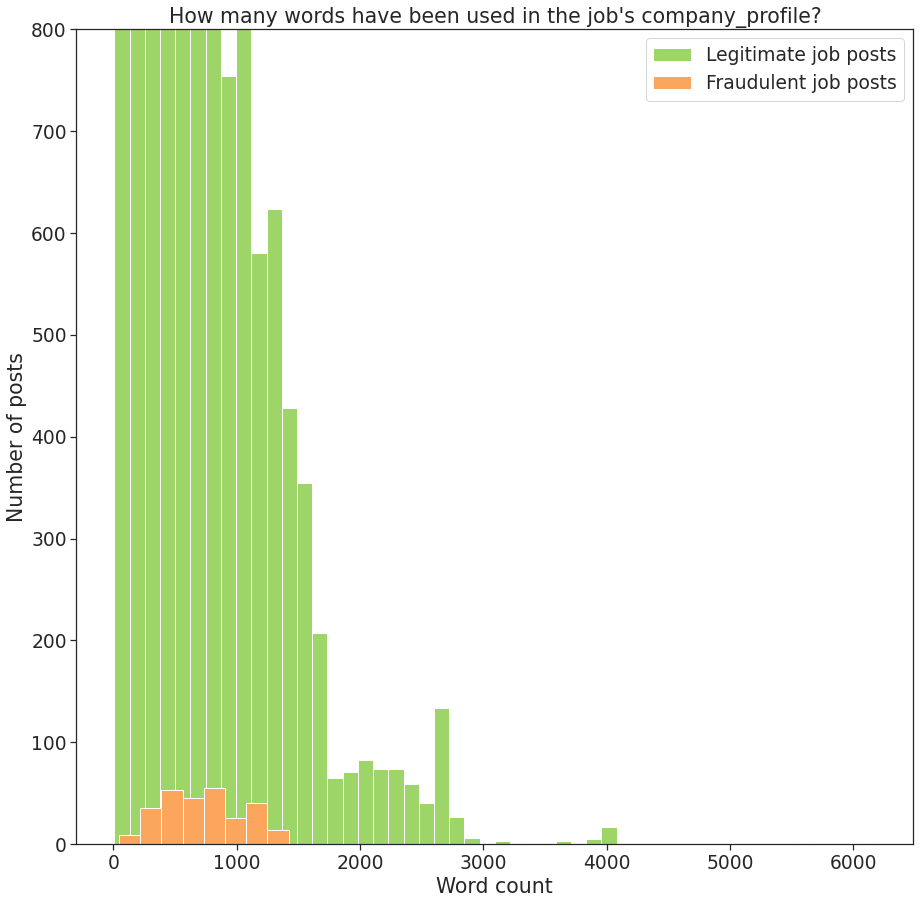

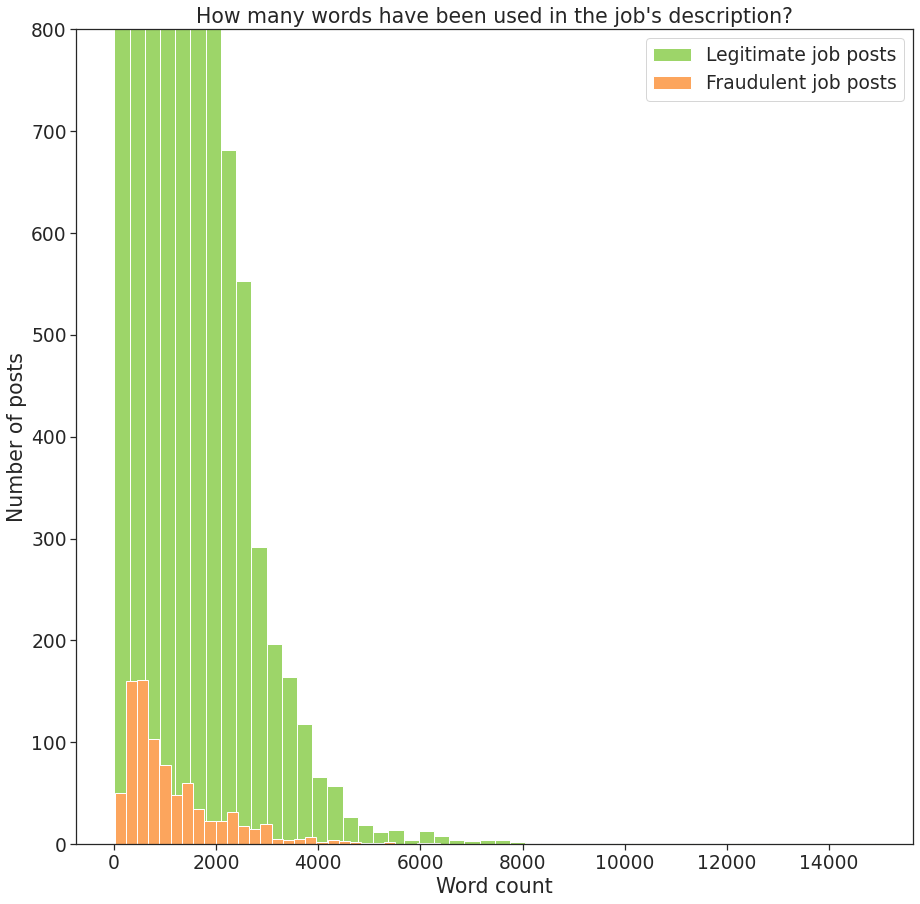

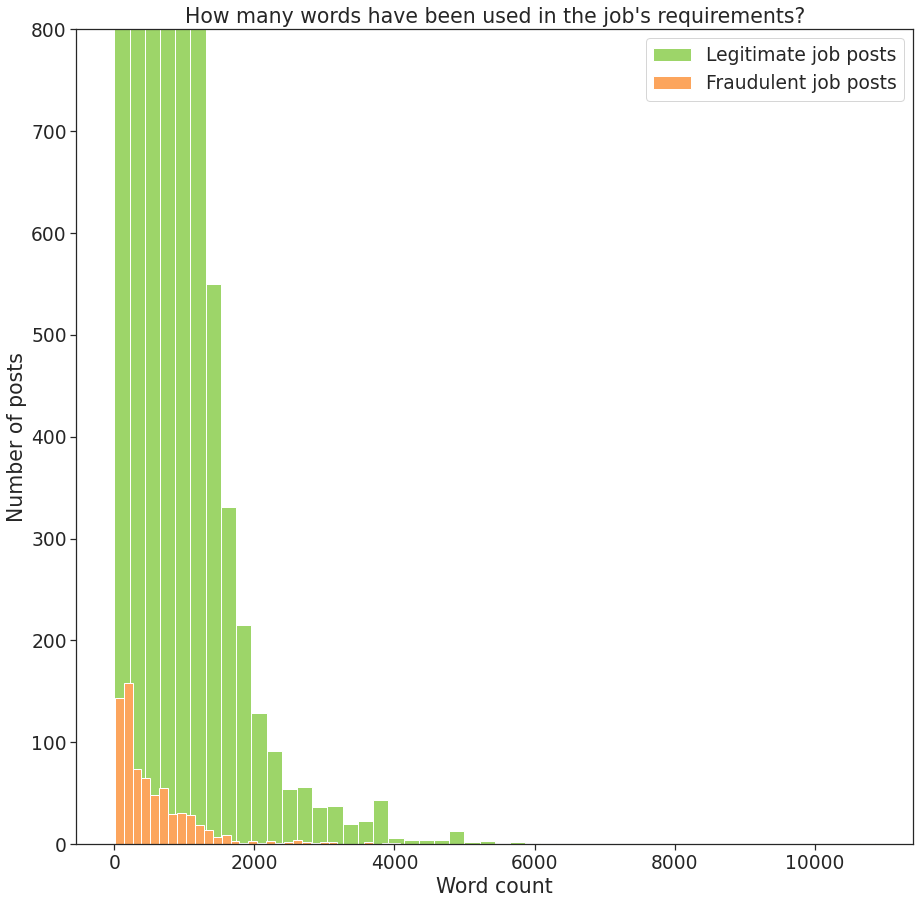

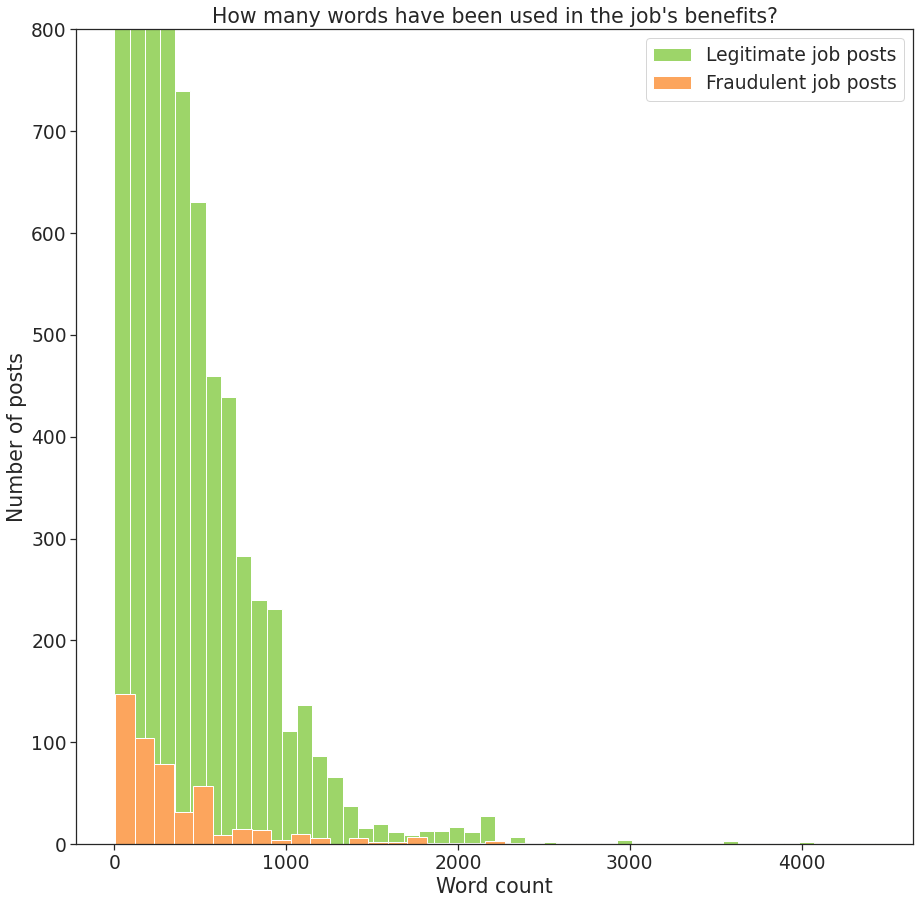

In [7]:
lib.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but even when there is information, the fraudulent job posts are less loquatious than legitimate job posts. Especially for job requirements and company_profile.

# Categorical information

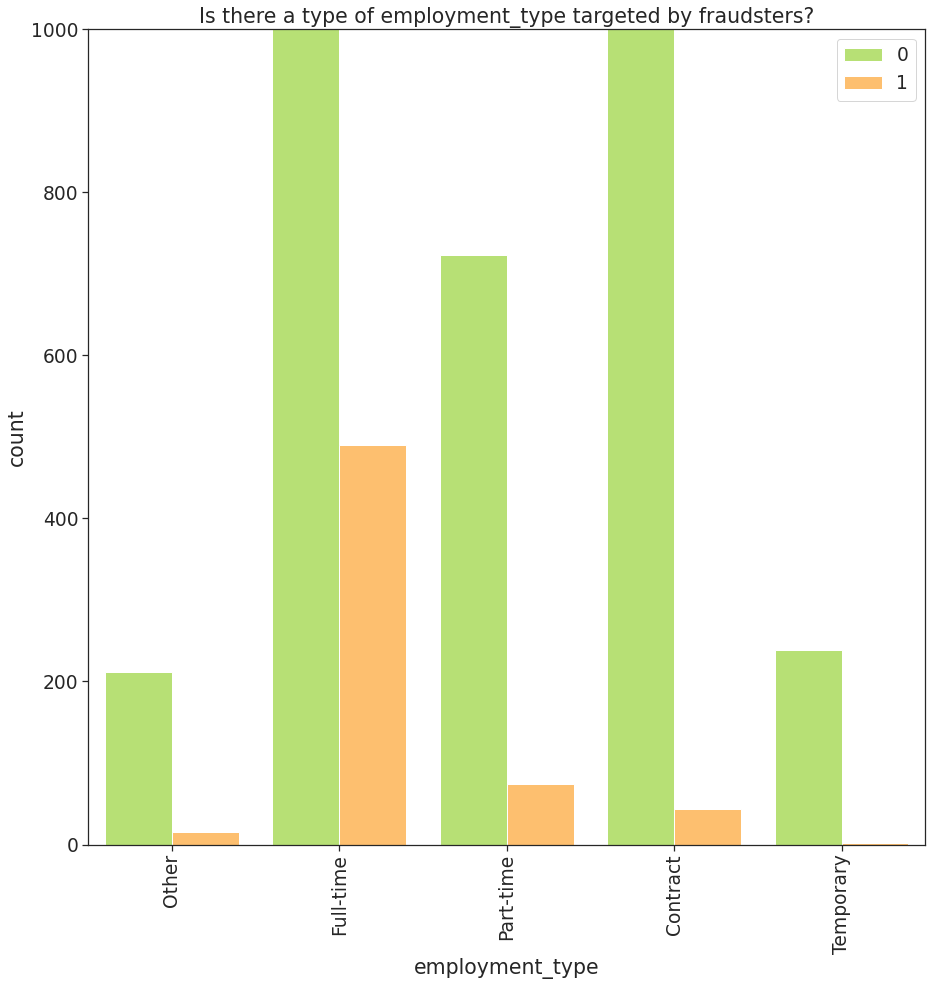

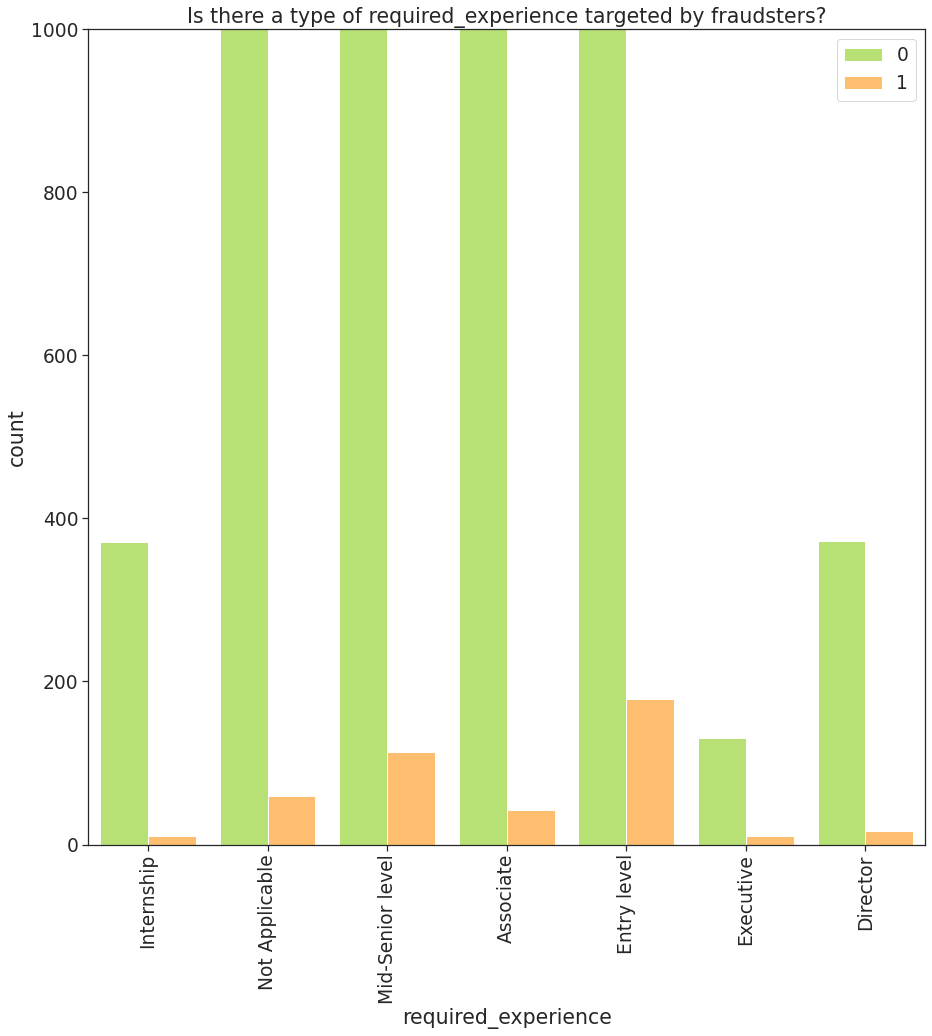

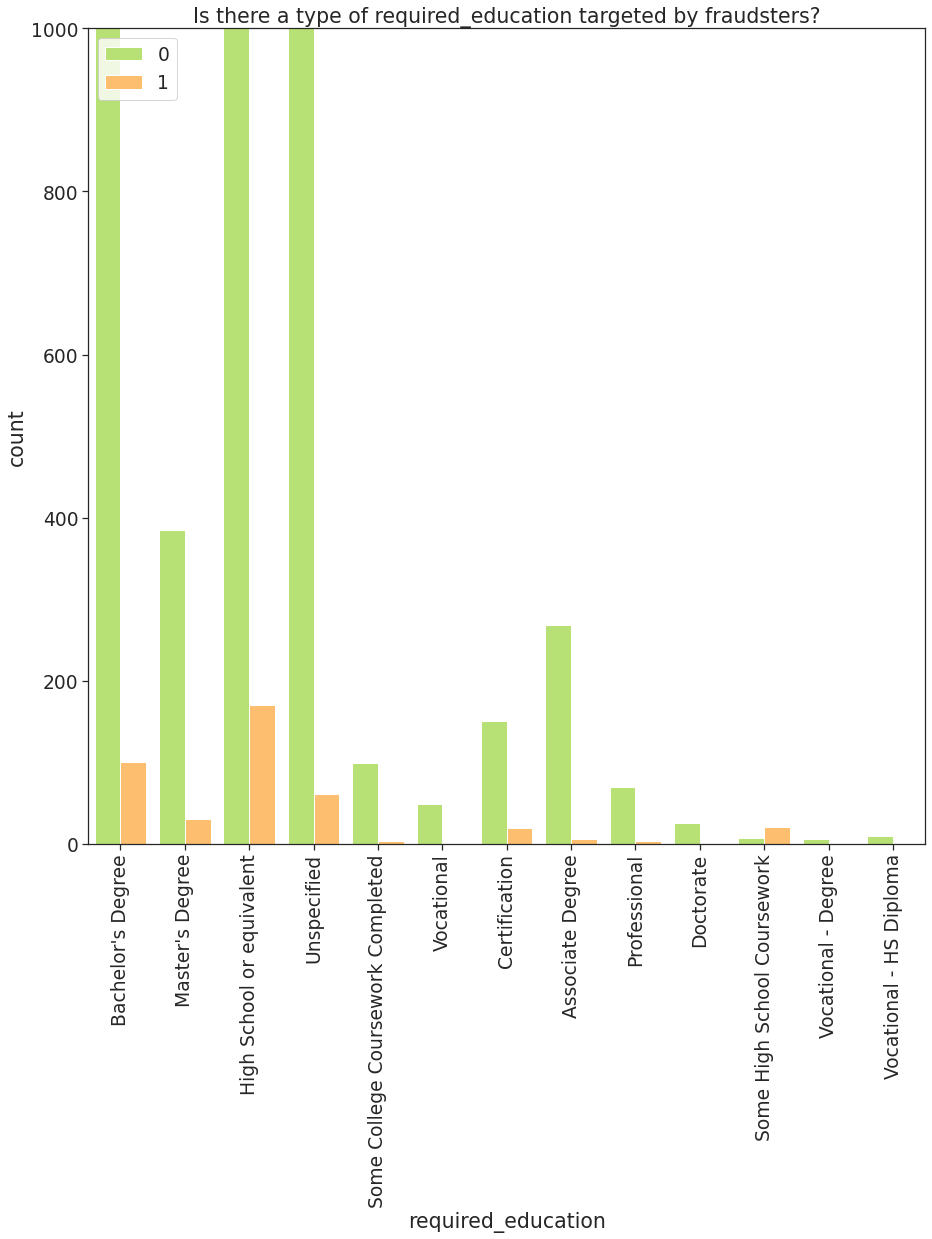

In [8]:
lib.count_plot(df,11,14)

# Extracting extra information

Some job offers have phone, email and/or external url information:

In [9]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

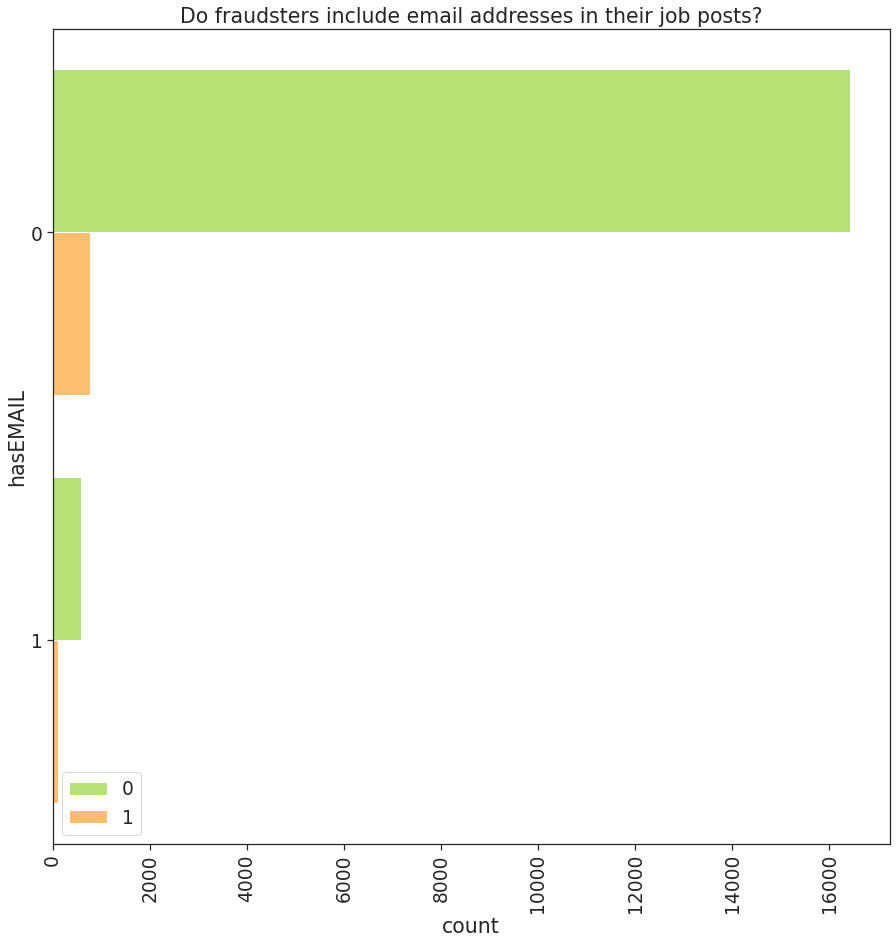

In [10]:
sns.countplot(y='hasEMAIL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

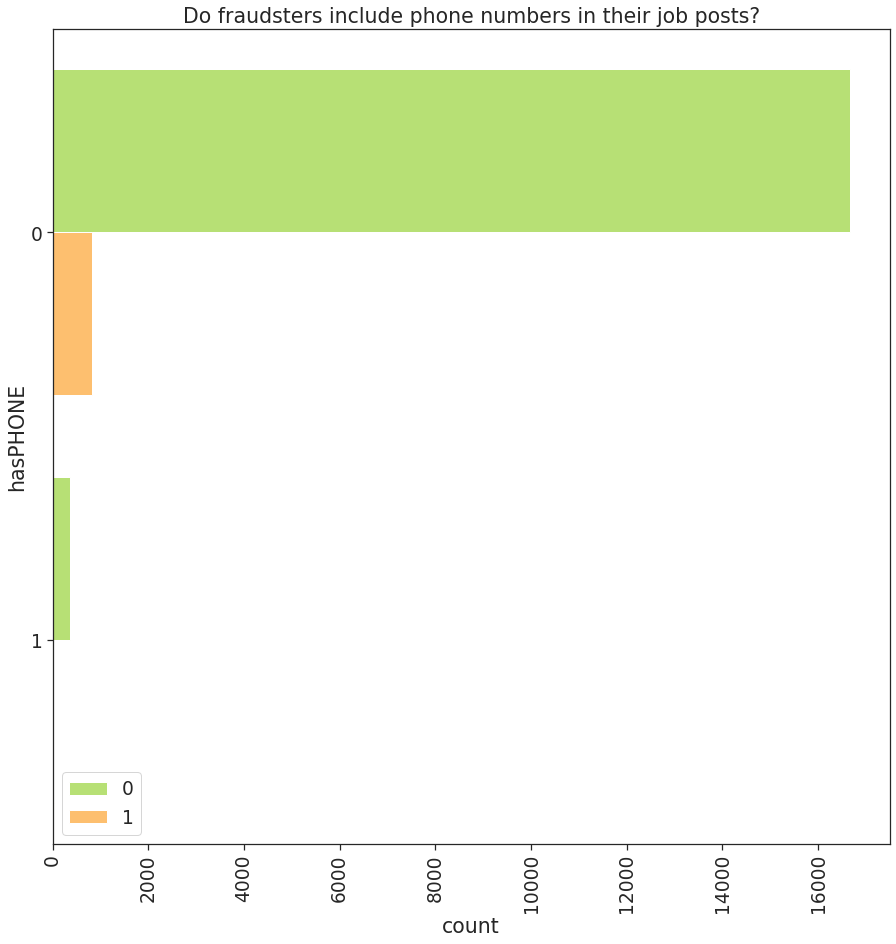

In [11]:
sns.countplot(y='hasPHONE', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

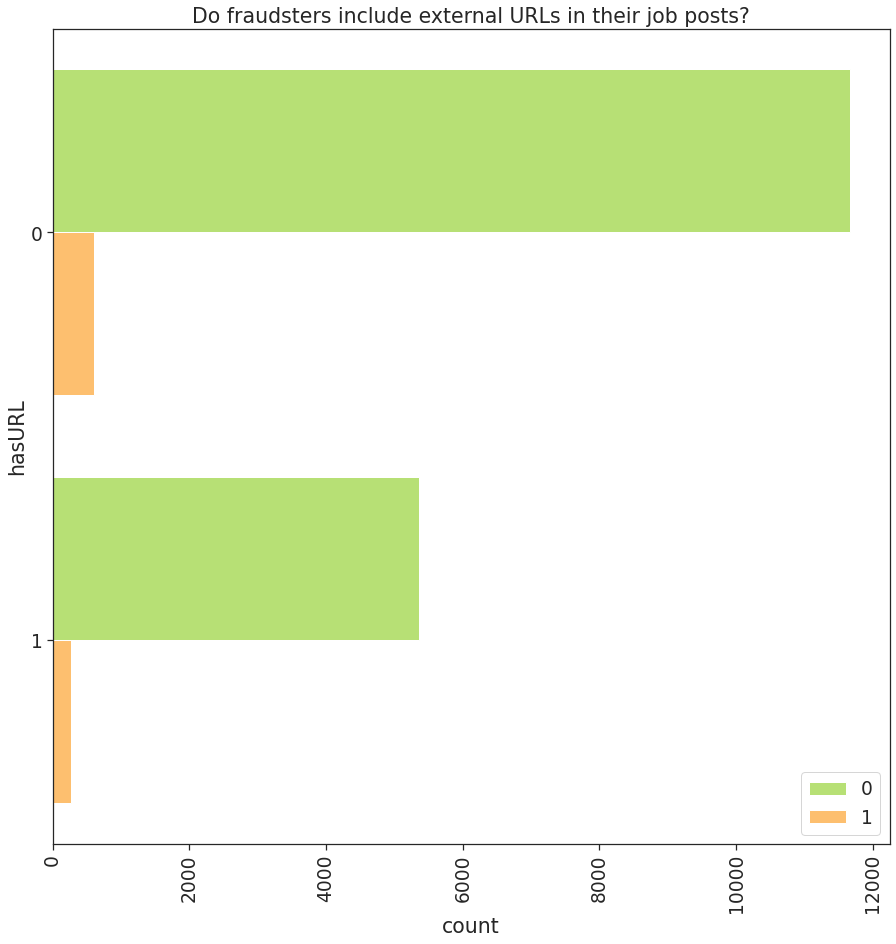

In [12]:
sns.countplot(y='hasURL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

# Conclusion

Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:

* they tend to be lacking more information than the legitimate job offers but fraudsters will make an effort for informations such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This is especially true for the company profile and the job requirements.

In terms of content, fraudulent posts will:

* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not specifically targeted, some even not targeted at all (in this dataset at least)
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but proportionally less than any other type of positions and temporary contracts were not targeted at all (in this dataset at least)
* target all type of experience but mainly entry level positions. Once again Associates are less exposed and Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but as phone, emails and urls have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding about fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.